<a href="https://colab.research.google.com/github/momotarogrp/open/blob/main/UTH_BERT_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTH-BERT を Tensorflow2.X / Keras BERT から利用して文書分類を行う

公式サイト

- [BERT(Google)](https://github.com/google-research/bert)

- [UTH-BERT](https://ai-health.m.u-tokyo.ac.jp/uth-bert) \([東京大学 医療AI開発学講座](https://ai-health.m.u-tokyo.ac.jp/)\)

- [Keras BERT](https://github.com/CyberZHG/keras-bert)

## 必要なライブラリ等の準備

### pythonライブラリのインストールとインポート

In [1]:
!pip install keras_bert
!pip install mecab-python3
!pip install jaconv
!pip install neologdn
!pip install tensorflow-addons

  Created wheel for keras-bert: filename=keras_bert-0.88.0-py3-none-any.whl size=34204 sha256=e4b4ab6caaef3695b3998db07c2a525ec77606fe4aa70942679cc224f2a18d87
  Stored in directory: /root/.cache/pip/wheels/a2/90/cd/c038f2366929a3a5e3414a303b673e10235e802d871d29a835
  Created wheel for keras-transformer: filename=keras_transformer-0.39.0-py3-none-any.whl size=12842 sha256=049c056f50a52182d9b141836c958297849d6da34aeaa11925e848d92ab6c4c0
  Stored in directory: /root/.cache/pip/wheels/bc/01/e0/5a1a14bed6726f2ed73f7917d2d2c2d4081d2c88426dea07ce
  Created wheel for keras-embed-sim: filename=keras_embed_sim-0.9.0-py3-none-any.whl size=4504 sha256=8cdcfae39970af19b9d35a7409064879db48243dd119f231953e4200f84db0cc
  Stored in directory: /root/.cache/pip/wheels/a8/1e/d2/9bc15513dd2f8b9de3e628b3aa9d2de49e721deef6bbd1497e
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.15.0-py3-none-any.whl size=5224 sha256=93393d1f25395e5b4c22004766b7c2ae16c52407e78eafce2f9b2217f

In [2]:
import os, sys
import tensorflow as tf
import pandas as pd
import numpy as np
import keras_bert

In [3]:
# tensorflowのバージョンを確認(2.3.0で動作確認済み)
tf.__version__

'2.6.0'

In [4]:
# Keras BERTのバージョンを確認（0.86.0で動作確認済み）
keras_bert.__version__

'0.88.0'

In [5]:
# Keras BERT で tf.keras を使用するための環境変数を設定
os.environ['TF_KERAS'] = '1'



### その他のライブラリとデータセットのダウンロードとインストール

In [6]:
# UTH-BERT
pretrained_model_dir_path = 'UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K'

!wget https://ai-health.m.u-tokyo.ac.jp/labweb/dl/uth_bert/UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K.zip
!unzip UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K.zip
# !rm UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K.zip
!git clone https://github.com/jinseikenai/uth-bert.git

# MeCab & NEologd
!apt install mecab libmecab-dev mecab-ipadic-utf8 file
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -a -y # 公式では -a オプションはついていないが多分必要
os.environ['MECABRC'] = "/etc/mecabrc" # 環境変数でmecabrcの場所を指定

# 万病辞書
!wget http://sociocom.jp/~data/2018-manbyo/data/MANBYO_201907_Dic-utf8.dic

# KNBコーパス
!wget http://nlp.ist.i.kyoto-u.ac.jp/kuntt/KNBC_v1.0_090925_utf8.tar.bz2
!tar -jxvf KNBC_v1.0_090925_utf8.tar.bz2
# !rm KNBC_v1.0_090925_utf8.tar.bz2

ストリーミング出力は最後の 5000 行に切り捨てられました。
KNBC_v1.0_090925_utf8/html/KN208_Kyoto_1-1-18-01-morph.html
KNBC_v1.0_090925_utf8/html/KN218_Gourmet_1-1-3-01.html
KNBC_v1.0_090925_utf8/html/KN221_Keitai_1-1-12-01-morph.html
KNBC_v1.0_090925_utf8/html/KN012_Sports_2-1-31-01.html
KNBC_v1.0_090925_utf8/html/KN215_Kyoto_1-1-26-01.html
KNBC_v1.0_090925_utf8/html/KN213_Keitai_1-1-3-01-morph.html
KNBC_v1.0_090925_utf8/html/KN039_Kyoto_1-1-28-01-morph.html
KNBC_v1.0_090925_utf8/html/KN238_Gourmet_1-1-26-01-morph.html
KNBC_v1.0_090925_utf8/html/KN217_Kyoto_1-1-20-01.html
KNBC_v1.0_090925_utf8/html/KN242_Kyoto_2-1-20-01.html
KNBC_v1.0_090925_utf8/html/KN209_Keitai_1-1-56-01-morph.html
KNBC_v1.0_090925_utf8/html/KN255_Kyoto_1-1-8-01-morph.html
KNBC_v1.0_090925_utf8/html/KN258_Keitai_1-1-8-02-morph.html
KNBC_v1.0_090925_utf8/html/KN002_Keitai_1-1-2-01-morph.html
KNBC_v1.0_090925_utf8/html/KN025_Kyoto_1-1-7-01-morph.html
KNBC_v1.0_090925_utf8/html/KN243_Gourmet_1-1-7-01-morph.html
KNBC_v1.0_090925_utf8/html/KN205_

## ディレクトリ・ファイルへのパスを設定

In [34]:
# データセット
knbc_dir_path = 'KNBC_v1.0_090925_utf8'
gourmet_tsv_file_path = os.path.join(knbc_dir_path, 'corpus2/Gourmet.tsv')
keitai_tsv_file_path = os.path.join(knbc_dir_path, 'corpus2/Keitai.tsv')
kyoto_tsv_file_path = os.path.join(knbc_dir_path, 'corpus2/Kyoto.tsv')
sports_tsv_file_path = os.path.join(knbc_dir_path, 'corpus2/Sports.tsv')

# 訓練済みモデル
# pretrained_model_dir_path = 'UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K'
pretrained_bert_config_file_path = os.path.join(pretrained_model_dir_path, 'config.json')
pretrained_model_checkpoint_path = os.path.join(pretrained_model_dir_path, 'model.ckpt-352000') # 拡張子不要
pretrained_vocab_file_path = os.path.join(pretrained_model_dir_path, 'vocab.txt')

# 今回学習するモデル
!mkdir train_model
train_model_dir_path = 'train_model'
train_bert_config_file_path = os.path.join(train_model_dir_path, 'train_bert_config.json')
train_model_checkpoint_path = os.path.join(train_model_dir_path, 'train_model.ckpt')

# NEologd辞書ディレクトリへのパス
import subprocess
cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
neologd_dic_dir_path = subprocess.check_output(cmd, shell=True).decode('utf-8').strip()

# 万病辞書へのパス
manbyo_dic_path = 'MANBYO_201907_Dic-utf8.dic'

mkdir: cannot create directory ‘train_model’: File exists


## KNBコーパスから今回用いるデータを抽出

In [8]:
# 各カテゴリのtsvファイルを読み込んでラベル列を追加
df_gourmet = pd.read_table(gourmet_tsv_file_path, header=None)
df_gourmet['label'] = 'グルメ'

df_keitai = pd.read_table(keitai_tsv_file_path, header=None)
df_keitai['label'] = '携帯電話'

df_kyoto = pd.read_table(kyoto_tsv_file_path, header=None)
df_kyoto['label'] = '京都観光'

df_sports = pd.read_table(sports_tsv_file_path, header=None)
df_sports['label'] = 'スポーツ'

# 結合して必要な列だけ抽出
df_dataset = pd.concat([df_gourmet, df_keitai, df_kyoto, df_sports])[[1, 'label']]
df_dataset.columns = ['text', 'label'] # ラベル名変更
df_dataset

,text,label
0,［グルメ］烏丸六角のおかき屋さん,グルメ
1,六角堂の前にある、蕪村庵というお店に行ってきた。,グルメ
2,おかきやせんべいの店なのだが、これがオイシイ。,グルメ
3,のれんをくぐると小さな庭があり、その先に町屋風の店内がある。,グルメ
4,せんべいの箱はデパートみたいな山積みではなく、間隔をあけて陳列されているのがまた良い。,グルメ
...,...,...
517,筋力が違う！！,スポーツ
518,なんか神様、不公平・・・,スポーツ
519,男性諸君、このこと忘れないでやぁ（＞◆＜）,スポーツ
520,まぁ。。。,スポーツ


### 学習用データとテスト用データに分割

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_dataset, test_size=500)

## 前処理用プログラムの動作確認

Tensorflow 2.X では tokenization_mod.py の tf.gfile.GFile を tf.io.gfile.GFile に変更しないとエラーになるので書き換える

In [10]:
# sed コマンドで tf.gfile.GFile を tf.io.gfile.GFile に置換
!sed -i-e 's/tf\.gfile\.GFile/tf\.io\.gfile\.GFile/g' ./uth-bert/tokenization_mod.py

In [13]:
pretrained_vocab_file_path
# !ls UTH_BERT_BASE_MC_BPE_V25000_10M

'UTH_BERT_BASE_MC_BPE_V25000_10M/vocab.txt'

https://github.com/jinseikenai/uth-bert の [example_main.py](https://github.com/jinseikenai/uth-bert/blob/master/example_main.py) の内容が実行できることを確認

In [17]:
sys.path.append('uth-bert')
from preprocess_text import preprocess as my_preprocess
from tokenization_mod import MecabTokenizer, FullTokenizerForMecab

if __name__ == '__main__':

    # special token for a Person's name (Do not change)
    name_token = "＠＠Ｎ"

    # path to the mecab-ipadic-neologd
    #mecab_ipadic_neologd = '/usr/lib/mecab/dic/mecab-ipadic-neologd' # 変更
    mecab_ipadic_neologd = neologd_dic_dir_path

    # path to the J-Medic (We used MANBYO_201907_Dic-utf8.dic)
    #mecab_J_medic = './MANBYO_201907_Dic-utf8.dic' # 変更
    mecab_J_medic = manbyo_dic_path

    # path to the uth-bert vocabulary
    #vocab_file = "./bert_vocab_mc_v1_25000.txt" # 変更
    vocab_file = pretrained_vocab_file_path

    # MecabTokenizer
    sub_tokenizer = MecabTokenizer(mecab_ipadic_neologd=mecab_ipadic_neologd,
                                   mecab_J_medic=mecab_J_medic,
                                   name_token=name_token)

    # FullTokenizerForMecab
    tokenizer = FullTokenizerForMecab(sub_tokenizer=sub_tokenizer,
                                      vocab_file=vocab_file,
                                      do_lower_case=False)

    # pre-process and tokenize example
    original_text = "2002 年夏より重い物の持ち上げが困難になり，階段の昇りが遅くなるなど四肢の筋力低下が緩徐に進行した．2005 年 2 月頃より鼻声となりろれつが回りにくくなった．また，食事中にむせるようになり，同年 12 月に当院に精査入院した。"
    print ('・Original text\n', original_text, end='\n\n')

    pre_processed_text = my_preprocess(original_text)
    print ('・After pre-processing\n', pre_processed_text, end='\n\n')

    output_tokens = tokenizer.tokenize(pre_processed_text)
    print ('・After tokenization\n', output_tokens)

・Original text
 2002 年夏より重い物の持ち上げが困難になり，階段の昇りが遅くなるなど四肢の筋力低下が緩徐に進行した．2005 年 2 月頃より鼻声となりろれつが回りにくくなった．また，食事中にむせるようになり，同年 12 月に当院に精査入院した。

・After pre-processing
 ２００２年夏より重い物の持ち上げが困難になり、階段の昇りが遅くなるなど四肢の筋力低下が緩徐に進行した．２００５年２月頃より鼻声となりろれつが回りにくくなった．また、食事中にむせるようになり、同年１２月に当院に精査入院した。

・After tokenization
 ['２００２年', '夏', 'より', '重い', '物', 'の', '持ち上げ', 'が', '困難', 'に', 'なり', '、', '階段', 'の', '[UNK]', 'が', '遅く', 'なる', 'など', '四肢', 'の', '筋力低下', 'が', '緩徐', 'に', '進行', 'し', 'た', '．', '２００５年', '２', '月頃', 'より', '鼻', '##声', 'と', 'なり', 'ろ', '##れ', '##つ', 'が', '回り', '##にく', '##く', 'なっ', 'た', '．', 'また', '、', '食事', '中', 'に', 'むせる', 'よう', 'に', 'なり', '、', '同年', '１２月', 'に', '当', '院', 'に', '精査', '入院', 'し', 'た', '。']


## 前処理を実行

### PreprocessingとTokenizationを学習用データとテスト用データに適用

In [18]:
def preprocess_text(s):
    result = []
    for text in s:
        result.append(my_preprocess(text))

    return result

In [19]:
train_text_preprocessed = preprocess_text(df_train['text'])
test_text_preprocessed = preprocess_text(df_test['text'])

# 先頭3つのデータを表示
for i in range(3):
    print(train_text_preprocessed[i])

さらに上へ行けるみたいでしたが、さすがにそこは断念して、引き返しました。
水を使うにしても噴水であって、自然の湖や池の縮尺版を表現するのではない。
天気予報は新聞やテレビではなく、インターネットで見る。


- Tokenization時に[CLS] と [SEP]を付加する

In [20]:
def tokenize_text(s):
    result = []
    for text in s:
        result.append(['[CLS]'] + tokenizer.tokenize(text) + ['[SEP]'])

    return result

In [21]:
train_text_tokenized = tokenize_text(df_train['text'])
test_text_tokenized = tokenize_text(df_test['text'])

# 先頭3つのデータを表示
for i in range(3):
    print(train_text_tokenized[i])

['[CLS]', 'さらに', '上', 'へ', '行ける', 'みたい', 'でし', 'た', 'が', '、', 'さすが', 'に', 'そこ', 'は', '断念', 'し', 'て', '、', '引き', '##返', '##し', 'まし', 'た', '。', '[SEP]']
['[CLS]', '水', 'を', '使う', 'に', 'し', 'て', 'も', '[UNK]', 'で', 'あっ', 'て', '、', '自然', 'の', '[UNK]', 'や', '池', 'の', '縮', '##尺', '版', 'を', '表現', 'する', 'の', 'で', 'は', 'ない', '。', '[SEP]']
['[CLS]', '天気', '##予', '##報', 'は', '新聞', 'や', 'テレビ', 'で', 'は', 'なく', '、', 'インターネット', 'で', '見る', '。', '[SEP]']


### 入力データの最大長を算出

In [22]:
# ファインチューニングする場合は学習データ・テストデータの最大長を用いる
maxlen = 0

for tokens in train_text_tokenized:
    maxlen = max(maxlen, len(tokens))

for tokens in test_text_tokenized:
    maxlen = max(maxlen, len(tokens))

maxlen

140

### テキストをトークン列から単語ID列に変換

In [23]:
def tokens_to_ids(tokenized_text):
    result = []
    for tokens in tokenized_text:
        result.append(tokenizer.convert_tokens_to_ids(tokens))

    return result

In [24]:
train_text_ids = tokens_to_ids(train_text_tokenized)
test_text_ids = tokens_to_ids(test_text_tokenized)

# 先頭3つのデータを表示
for i in range(3):
    print(train_text_ids[i])

[2, 1310, 195, 89, 6268, 906, 556, 19, 18, 5, 16995, 14, 2326, 15, 11414, 16, 13, 5, 4121, 9780, 1767, 108, 19, 6, 3]
[2, 707, 25, 3477, 14, 16, 13, 33, 1, 21, 121, 13, 5, 2142, 10, 1, 110, 9959, 10, 5452, 20594, 10828, 25, 6257, 45, 10, 21, 15, 42, 6, 3]
[2, 13769, 6848, 23256, 15, 6421, 110, 1879, 21, 15, 77, 5, 16681, 21, 1440, 6, 3]


### 単語ID列をリストからnumpy arrayに変換

In [25]:
def list_to_numpy_array(input_list, maxlen):
    result = np.zeros((len(input_list), maxlen), dtype=np.int32)

    for i in range(len(input_list)):
        for j in range(len(input_list[i])):
            result[i][j] = input_list[i][j]

    return result

In [26]:
X_train = list_to_numpy_array(train_text_ids, maxlen)
X_test = list_to_numpy_array(test_text_ids, maxlen)

# 先頭3つのデータを表示
X_train[:3]

array([[    2,  1310,   195,    89,  6268,   906,   556,    19,    18,
            5, 16995,    14,  2326,    15, 11414,    16,    13,     5,
         4121,  9780,  1767,   108,    19,     6,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

### ラベルデータを入力形式に変換

kerasのクラス分類のラベルデータはOne-hotエンコーディング

In [27]:
# ラベル -> インデックス の対応
label2index = {k: i for i, k in enumerate(df_train['label'].unique())}

# インデックス -> ラベル の対応
index2label = {i: k for i, k in enumerate(df_train['label'].unique())}

# ラベルの分類クラス数
class_count = len(label2index)
print('class count = ', class_count)

# One-hot encoding
y_train = tf.keras.utils.to_categorical([label2index[label] for label in df_train['label']], num_classes=class_count)
y_test = tf.keras.utils.to_categorical([label2index[label] for label in df_test['label']], num_classes=class_count)

# 先頭3つのデータを表示
print(y_train[:3])

class count =  4
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


## コンフィグファイルの準備

### 訓練済みモデルのBERTコンフィグファイルをロード

In [30]:
import json
from pprint import pprint as pp

json_open = open(pretrained_bert_config_file_path, 'r')
pretrained_bert_config =json.load(json_open)

pp(pretrained_bert_config)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 25000}


### 学習用BERTコンフィグファイルを作成

max_position_embedding と max_seq_length を今回使用するデータのトークンの最大長に設定する

In [31]:
train_bert_config = pretrained_bert_config
train_bert_config['max_position_embeddings'] = maxlen
train_bert_config['max_seq_length'] = maxlen

pp(train_bert_config)

# jsonファイルとして保存
with open(train_bert_config_file_path, 'w') as f:
    json.dump(train_bert_config, f, indent=4)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 140,
 'max_seq_length': 140,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 25000}


## 学習

### 学習パラメータの設定

In [32]:
BATCH_SIZE = 16
EPOCHS = 20
LR = 1e-4

### 訓練済みBERTモデルのロード

In [35]:
from keras_bert import load_trained_model_from_checkpoint
bert = load_trained_model_from_checkpoint(train_bert_config_file_path, pretrained_model_checkpoint_path, training=True, trainable=True, seq_len=maxlen)
bert.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 140)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 140)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 140, 768), ( 19200000    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 140, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

### 学習用モデルの定義

In [76]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
from keras_bert import AdamWarmup, calc_train_steps
import tensorflow_addons as tfa
# from tensorflow.keras.optimizers import Adam as tfAdam
#     mb_in_mb.compile(tfAdam(), 'mse')    #----※1
def _create_model(bert, maxlen, class_count):
    bert_last = bert.get_layer(name='NSP-Dense').output #  NSP-Denseを指定する理由は要確認
    output_tensor = Dense(class_count, activation='softmax')(bert_last)

    model = Model([bert.input[0], bert.input[1]], output_tensor)

    # decay_steps, warmup_steps = calc_train_steps(
    #     maxlen,
    #     batch_size=BATCH_SIZE,
    #     epochs=EPOCHS,
    # )

    # 例えば150エポック以降で学習率を1/10したい場合は以下の様にOptimizerに渡す。
    # steps_per_epoch = 100
    # lr_schedule = BaseSchedule(lr=0.001, decay_start=steps_per_epoch*150, decay_ratio=0.1)
    # steps_per_epoch = 100
    # lr_schedule = BaseSchedule(lr=LR, decay_start=EPOCHS, decay_ratio=0.1)
    # optimizer = tf.keras.optimizers.Adam( learning_rate = lr_schedule )
    optimizer = tfa.optimizers.RectifiedAdam(
        lr=1e-3,
        total_steps=10000,
        warmup_proportion=0.1,
        min_lr=1e-5,
    )
    # optimizer='nadam' では収束しないのでAdamWarmupを用いる
    model.compile(
        loss='categorical_crossentropy',
        optimizer = optimizer,
        # optimizer=AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=LR),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
# model = keras.models.Model(inputs, outputs)
# model.compile(AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=LR),
#     loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
# model.summary()
    return model

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [77]:
model = _create_model(bert, maxlen, class_count)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 140)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 140)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 140, 768), ( 19200000    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 140, 768)     1536        Input-Segment[0][0]              
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### 学習を実行

In [79]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# BATCH_SIZE = 16
# EPOCHS = 20
# LR = 1e-4
history = model.fit(
    [X_train, np.zeros_like(X_train)],
    y_train,
    # epochs = EPOCHS,
    # batch_size = BATCH_SIZE,
    epochs = 10,
    batch_size = 5,
    validation_split=0.1,
    shuffle=True,
    verbose = 1,
    callbacks = [
        EarlyStopping(patience=5, monitor='val_accuracy', mode='max'),
        ModelCheckpoint(monitor='val_accuracy', mode='max', filepath=train_model_checkpoint_path, save_best_only=True)
    ]
)

Epoch 1/10
664/664 [==============================] - 439s 660ms/step - loss: 1.3934 - accuracy: 0.3235 - precision_3: 0.3842 - recall_3: 0.0585 - val_loss: 1.3651 - val_accuracy: 0.3144 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/10
664/664 [==============================] - 424s 639ms/step - loss: 1.3751 - accuracy: 0.3208 - precision_3: 0.2927 - recall_3: 0.0326 - val_loss: 1.3710 - val_accuracy: 0.2087 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/10
664/664 [==============================] - 431s 650ms/step - loss: 1.3624 - accuracy: 0.3211 - precision_3: 0.3155 - recall_3: 0.0160 - val_loss: 1.3626 - val_accuracy: 0.3469 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/10
664/664 [==============================] - 416s 627ms/step - loss: 1.3452 - accuracy: 0.3346 - precision_3: 0.3636 - recall_3: 0.0024 - val_loss: 1.3265 - val_accuracy: 0.3144 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 5/10
664/664 [====

Epoch 1/10
664/664 [==============================] - 439s 660ms/step - loss: 1.3934 - accuracy: 0.3235 - precision_3: 0.3842 - recall_3: 0.0585 - val_loss: 1.3651 - val_accuracy: 0.3144 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision_3,recall_3,val_loss,val_accuracy,val_precision_3,val_recall_3
WARNING:tensorflow:Can save best model only with val_acc available, skipping.
Epoch 2/10
664/664 [==============================] - 424s 639ms/step - loss: 1.3751 - accuracy: 0.3208 - precision_3: 0.2927 - recall_3: 0.0326 - val_loss: 1.3710 - val_accuracy: 0.2087 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision_3,recall_3,val_loss,val_accuracy,val_precision_3,val_recall_3
WARNING:tensorflow:Can save best model only with val_acc available, skipping.
Epoch 3/10
664/664 [==============================] - 431s 650ms/step - loss: 1.3624 - accuracy: 0.3211 - precision_3: 0.3155 - recall_3: 0.0160 - val_loss: 1.3626 - val_accuracy: 0.3469 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision_3,recall_3,val_loss,val_accuracy,val_precision_3,val_recall_3
WARNING:tensorflow:Can save best model only with val_acc available, skipping.
Epoch 4/10
664/664 [==============================] - 416s 627ms/step - loss: 1.3452 - accuracy: 0.3346 - precision_3: 0.3636 - recall_3: 0.0024 - val_loss: 1.3265 - val_accuracy: 0.3144 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision_3,recall_3,val_loss,val_accuracy,val_precision_3,val_recall_3
WARNING:tensorflow:Can save best model only with val_acc available, skipping.
Epoch 5/10
664/664 [==============================] - 418s 630ms/step - loss: 1.3407 - accuracy: 0.3331 - precision_3: 0.3158 - recall_3: 0.0018 - val_loss: 1.3267 - val_accuracy: 0.3469 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision_3,recall_3,val_loss,val_accuracy,val_precision_3,val_recall_3
WARNING:tensorflow:Can save best model only with val_acc available, skipping.
Epoch 6/10
664/664 [==============================] - 441s 664ms/step - loss: 1.3339 - accuracy: 0.3380 - precision_3: 0.2500 - recall_3: 3.0148e-04 - val_loss: 1.3264 - val_accuracy: 0.3469 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision_3,recall_3,val_loss,val_accuracy,val_precision_3,val_recall_3
WARNING:tensorflow:Can save best model only with val_acc available, skipping.
Epoch 7/10
664/664 [==============================] - 441s 664ms/step - loss: 1.3440 - accuracy: 0.3371 - precision_3: 0.2500 - recall_3: 0.0030 - val_loss: 1.3268 - val_accuracy: 0.3469 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision_3,recall_3,val_loss,val_accuracy,val_precision_3,val_recall_3
WARNING:tensorflow:Can save best model only with val_acc available, skipping.
Epoch 8/10
664/664 [==============================] - 446s 672ms/step - loss: 1.3274 - accuracy: 0.3491 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 1.3265 - val_accuracy: 0.3469 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision_3,recall_3,val_loss,val_accuracy,val_precision_3,val_recall_3
WARNING:tensorflow:Can save best model only with val_acc available, skipping.
Epoch 9/10
664/664 [==============================] - 445s 670ms/step - loss: 1.3252 - accuracy: 0.3389 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 1.3304 - val_accuracy: 0.3469 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision_3,recall_3,val_loss,val_accuracy,val_precision_3,val_recall_3
WARNING:tensorflow:Can save best model only with val_acc available, skipping.
Epoch 10/10
664/664 [==============================] - 443s 667ms/step - loss: 1.3290 - accuracy: 0.3401 - precision_3: 1.0000 - recall_3: 6.0295e-04 - val_loss: 1.3234 - val_accuracy: 0.3469 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,precision_3,recall_3,val_loss,val_accuracy,val_precision_3,val_recall_3
WARNING:tensorflow:Can save best model only with val_acc available, skipping.

In [80]:
pd.DataFrame(history.history)

,loss,accuracy,precision_3,recall_3,val_loss,val_accuracy,val_precision_3,val_recall_3
0,1.393416,0.323485,0.384158,0.058487,1.365072,0.314363,0.0,0.0
1,1.375149,0.320772,0.292683,0.032560,1.371005,0.208672,0.0,0.0
2,1.362397,0.321073,0.315476,0.015978,1.362608,0.346883,0.0,0.0
3,1.345217,0.334640,0.363636,0.002412,1.326508,0.314363,0.0,0.0
4,1.340690,0.333132,0.315789,0.001809,1.326697,0.346883,0.0,0.0
5,1.333906,0.337956,0.250000,0.000301,1.326403,0.346883,0.0,0.0
6,1.343997,0.337052,0.250000,0.003015,1.326799,0.346883,0.0,0.0
7,1.327359,0.349111,0.000000,0.000000,1.326540,0.346883,0.0,0.0
8,1.325168,0.338860,0.000000,0.000000,1.330384,0.346883,0.0,0.0
9,1.329044,0.340066,1.000000,0.000603,1.323424,0.346883,0.0,0.0


### 学習曲線を表示

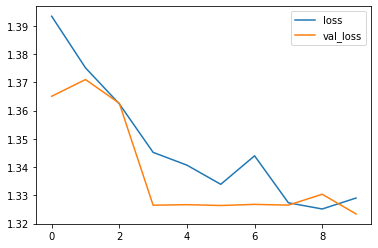

In [81]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

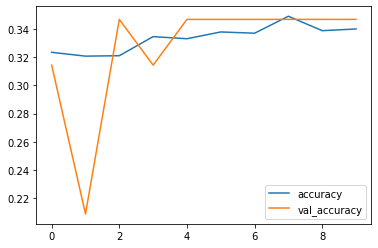

In [85]:
# Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [88]:
train_model_checkpoint_path

'train_model/train_model.ckpt'

## テスト用データで予測

In [86]:
from tensorflow.keras.models import load_model
from keras_bert import get_custom_objects

# 学習中に保存した最良モデルをロード (tensorflow2.1ではエラーになります)
model = load_model(train_model_checkpoint_path, custom_objects=get_custom_objects())

# 予測を実行
y_test_pred_proba = model.predict([X_test, np.zeros_like(X_test)])

# 先頭3つのデータを表示
y_test_pred_proba[:3]

OSError: ignored

### 結果レポート

In [87]:
from sklearn.metrics import classification_report, confusion_matrix

y_test_true_labels = y_test.argmax(axis=1) # Probability -> index
y_test_pred_labels = y_test_pred_proba.argmax(axis=1) # One-hot -> index

target_names = [index2label[i] for i in range(class_count)]
rep = classification_report(y_test_true_labels, y_test_pred_labels, target_names=target_names, output_dict=True)

pd.DataFrame(rep)

NameError: ignored